# Unit 2 Lesson 5 Challenge: Validating a linear regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
from sklearn import preprocessing
import math
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score

In [2]:
fbi_data = pd.read_csv('GAcrime2013.csv')

### Exploring the data

In [3]:
fbi_data.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Abbeville,"2,888",3,0,nan,0,2,1,22,3,16,3,0.000
1,Adairsville,"4,686",13,0,nan,0,1,12,52,15,31,6,0.000
2,Adel,"5,240",18,0,nan,5,5,8,189,64,121,4,0.000
3,Adrian,656,0,0,nan,0,0,0,2,0,2,0,0.000
4,Alapaha,646,5,0,nan,0,1,4,6,0,6,0,0.000


In [4]:
fbi_data.describe()

,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Arson3
count,253.000,0.000,253.000,176.000
mean,1.115,nan,3.146,2.125
std,5.960,nan,9.060,7.627
min,0.000,nan,0.000,0.000
25%,0.000,nan,0.000,0.000
50%,0.000,nan,0.000,0.000
75%,0.000,nan,2.000,1.000
max,84.000,nan,105.000,71.000


### Data Cleaning

In [5]:
fbi_data = fbi_data.drop(['Rape\n(revised\ndefinition)1'], axis =1)

In [6]:
fbi_data.columns = ['City', 'Population', 'ViolentCrime', 'Murder', 'Rape2', 'Robbery', 'AggAssault', 'PropCrime', 'Burglary', 'Larceny', 'AutoTheft', 'Arson']

In [7]:
fbi_data = fbi_data.fillna(0)

In [8]:
fbi_data.tail(10)

,City,Population,ViolentCrime,Murder,Rape2,Robbery,AggAssault,PropCrime,Burglary,Larceny,AutoTheft,Arson
243,Waverly Hall,737,0,0,0,0,0,8,3,4,1,0.000
244,Waycross,"14,206",64,1,1,27,35,946,114,817,15,6.000
245,Waynesboro,"5,793",32,0,2,7,23,134,32,90,12,0.000
246,West Point,"3,539",21,0,0,9,12,138,35,95,8,0.000
247,Willacoochee,"1,366",4,0,0,1,3,37,14,23,0,0.000
248,Winder,"14,291",59,0,6,11,42,639,111,489,39,0.000
249,Winterville,"1,137",0,0,0,0,0,11,4,7,0,0.000
250,Woodbury,911,2,0,0,0,2,23,4,18,1,0.000
251,Woodstock,"25,515",20,0,3,6,11,594,47,534,13,0.000
252,Wrens,2096,10,0,2,1,7,79,8,71,0,0.000


In [9]:
# Need to convert the column's data from strings

fbi_data['Arson'] = fbi_data['Arson'].astype(int)
fbi_data['Robbery'] = fbi_data['Robbery'].str.replace(',', '')
fbi_data['Population'] = fbi_data['Population'].str.replace(',', '')
fbi_data['Robbery'] = fbi_data['Robbery'].astype(int)
fbi_data['Population'] = fbi_data['Population'].astype(int)
fbi_data['PropCrime'] = fbi_data['PropCrime'].str.replace(',', '')
fbi_data['Larceny'] = fbi_data['Larceny'].str.replace(',', '')
fbi_data['AutoTheft'] = fbi_data['AutoTheft'].str.replace(',', '')
fbi_data['PropCrime'] = fbi_data['PropCrime'].astype(int)
fbi_data['Rape2'] = fbi_data['Rape2'].astype(int)

In [10]:
fbi_data['Rape2'] = fbi_data['Rape2'].apply(lambda x: 1 if x >= 1 else 0)
fbi_data['Robbery'] = fbi_data['Robbery'].apply(lambda x: 1 if x >= 1 else 0)
new_fbi_data_col = ["Population", "Rape2", "PropCrime", 'Robbery']
new_fbi_data = fbi_data[new_fbi_data_col]

###  Creating a new feature and fitting the model

In [11]:
regr = linear_model.LinearRegression()
new_data = new_fbi_data[(np.abs(stats.zscore(new_fbi_data)) <= 1.5).all(axis=1)]
new_data = np.sqrt(new_fbi_data)
Y = new_data['PropCrime'].values.reshape(-1, 1)
X = new_data[["Population", "Rape2", "Robbery"]]
regr.fit(X, Y)
new_predicted = regr.predict(X).ravel()
new_actual = new_data['PropCrime']
# Calculate the error, also called the residual.
new_res = new_actual - new_predicted
# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 0.20902701  0.86814617  2.23811586]]

Intercept: 
 [-2.91731235]

R-squared:
0.886235779218


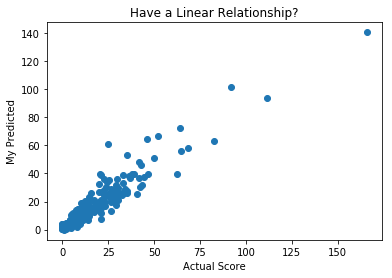

In [12]:
# the model has a linear relationship
plt.scatter(new_actual, new_predicted)
plt.title('Have a Linear Relationship?')
plt.xlabel('Actual Score')
plt.ylabel('My Predicted')
plt.show()

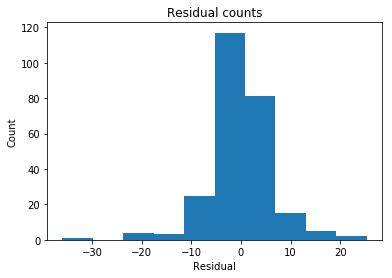

In [13]:
plt.hist(new_res)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')

plt.show()

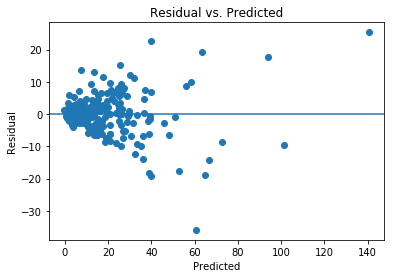

In [14]:
# the errors are not as consistant as they were with New York's data
plt.scatter(new_predicted, new_res)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [15]:
# the correlation is higher than it was with New York
correlation_matrix = X.corr()
display(correlation_matrix)

,Population,Rape2,Robbery
Population,1.000,0.504,0.460
Rape2,0.504,1.000,0.476
Robbery,0.460,0.476,1.000


In [16]:
linear_formula = 'new_data.PropCrime ~ Population+Rape2+Robbery'
lm = smf.ols(formula= linear_formula, data=new_data).fit()

In [17]:
lm.params

Intercept    -2.917
Population    0.209
Rape2         0.868
Robbery       2.238
dtype: float64

In [18]:
# Rape2 p-values are much higher than 0.05 and would not be a good feature to use for Georgia's dataset 
lm.pvalues

Intercept    0.000
Population   0.000
Rape2        0.366
Robbery      0.021
dtype: float64

In [19]:
lm.rsquared

0.88623577921815522

In [20]:
lm.conf_int()

,0,1
Intercept,-4.269,-1.565
Population,0.197,0.221
Rape2,-1.019,2.755
Robbery,0.335,4.141


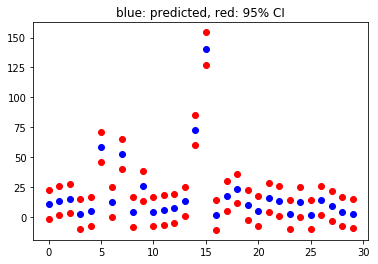

In [21]:
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:30], 'o', color='r')
plt.plot(iv_l[0:30], 'o', color='r')
plt.plot(lm.fittedvalues[0:30], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

In [22]:
bnb = BernoulliNB()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
bnb.fit(X, Y)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(XY).score(X, Y)))
cross_val_score(bnb, X, Y, cv=10)

C:\Users\blindside\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: (array([   4.69041576,    7.21110255,   13.74772708,    1.41421356,
          2.44948974,   68.27151675,   14.4222051 ,   35.04283094,
          5.29150262,   35.29872519,    7.14142843,    5.91607978,
         11.13552873,   13.56465997,   63.82789359,  165.91564122,
          1.41421356,   13.82027496,   23.83275058,    7.        ,
          3.46410162,   18.08314132,   17.        ,    0.        ,
         12.24744871,    4.58257569,   14.31782106,    7.87400787,
          4.79583152,    3.74165739,    6.92820323,    8.54400375,
         11.26942767,    0.        ,   13.15294644,    3.31662479,
         33.3166625 ,    6.55743852,    8.66025404,    4.89897949,
         12.24744871,   14.89966443,   28.        ,   20.14944168,
         33.01514804,   30.4466747 ,    4.24264069,   30.33150178,
         20.39607805,   12.72792206,    6.244998  ,    8.24621125,
         17.66352173,   12.16552506,    9.8488578 ,   14.35270009,
          0.        ,   15.71623365,   40.79215611,    8.30662386,
        111.69153952,   10.72380529,   32.34192326,    2.        ,
         29.10326442,   13.6381817 ,   27.58622845,    7.41619849,
         36.31803959,    4.69041576,    9.21954446,   26.26785107,
          4.58257569,    2.64575131,    6.55743852,   10.29563014,
         20.174241  ,   29.71531592,   44.71017781,   34.43835072,
         25.59296778,   42.87190222,    9.32737905,   21.21320344,
         62.4899992 ,   14.73091986,    4.12310563,   17.57839583,
          4.12310563,    4.69041576,    7.61577311,    0.        ,
          4.24264069,   11.26942767,   22.56102835,    2.23606798,
         22.64950331,   22.36067977,    9.74679434,    8.54400375,
         15.23154621,   26.36285265,   20.88061302,    4.89897949,
          3.        ,   38.79432948,   20.59126028,   11.74734012,
          2.        ,    4.69041576,    8.24621125,   12.72792206,
          5.29150262,   43.38202393,   14.59451952,    6.78232998,
         10.63014581,   23.06512519,    6.164414  ,    0.        ,
         13.41640786,    7.87400787,    5.38516481,   38.        ,
         21.26029163,    2.44948974,    9.89949494,    0.        ,
         14.2126704 ,    9.74679434,   12.20655562,    3.        ,
         28.74021573,   24.87971061,   15.        ,   22.42766149,
         21.63330765,   20.27313493,   41.64132563,    8.54400375,
          3.74165739,   11.91637529,   29.51270913,   26.70205985,
          6.4807407 ,   18.24828759,   17.43559577,    4.35889894,
          4.35889894,    0.        ,   82.46211251,   14.93318452,
         13.22875656,   49.989999  ,    5.19615242,   28.93095228,
          4.69041576,    8.42614977,    4.89897949,    0.        ,
          8.42614977,   29.59729717,   20.46948949,   32.51153641,
         12.60952021,   29.24038303,   31.63858404,    3.87298335,
         16.4924225 ,    3.16227766,   32.89376841,    3.16227766,
          6.        ,   26.40075756,   17.11724277,   11.70469991,
         13.89244399,    5.65685425,    2.        ,    1.73205081,
         20.95232684,   12.80624847,    7.14142843,   15.84297952,
          7.28010989,   23.74868417,    8.        ,   10.86278049,
          4.89897949,   26.98147513,   14.76482306,    1.73205081,
          0.        ,   14.76482306,   13.78404875,   28.74021573,
          6.78232998,   20.63976744,   46.66904756,   26.60826939,
         45.90206967,   17.        ,   52.33545643,   91.96738552,
          4.12310563,    6.70820393,    1.        ,    1.73205081,
         41.73727351,   28.63564213,   14.38749457,    9.79795897,
          6.08276253,    7.87400787,   36.89173349,   21.04756518,
         22.84731932,    7.07106781,   19.77371993,   11.09053651,
          5.        ,    1.        ,    8.36660027,   34.14674216,
          9.38083152,   35.42597917,    1.73205081,   23.40939982,
          4.35889894,    6.40312424,    4.79583152,    8.48528137,
          9.94987437,   42.46174749,    9.2736185 ,   26.64582519,
         25.27844932,   12.64911064,    4.79583152,   64.90762667,
          8.48528137,   11.09053651,    8.30662386,    2.82842712,
         30.757113  ,   11.5758369 ,   11.74734012,    6.08276253,
         25.27844932,    3.31662479,    4.79583152,   24.37211521,
          8.88819442]),)

In [23]:
# decided to remove the Rape2 feature because of the high pvalue and we will see the new results
Y = new_data['PropCrime'].values.reshape(-1, 1)
X = new_data[["Population", "Robbery"]]
regr.fit(X, Y)
new_ed_pred = regr.predict(X).ravel()
new_actual = new_data['PropCrime']
# Calculate the error, also called the residual.
new_ed_res = new_actual - new_ed_pred
# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 0.211015    2.51698854]]

Intercept: 
 [-2.86211885]

R-squared:
0.885860610811


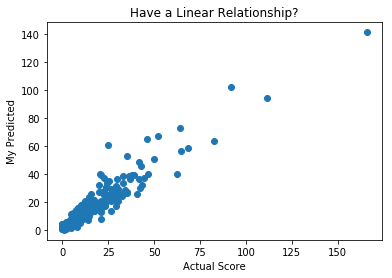

In [24]:
plt.scatter(new_actual, new_ed_pred)
plt.title('Have a Linear Relationship?')
plt.xlabel('Actual Score')
plt.ylabel('My Predicted')
plt.show()

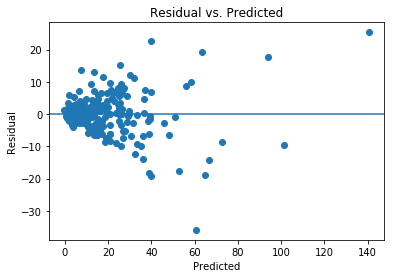

In [25]:
plt.scatter(new_predicted, new_res)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [26]:
correlation_matrix = X.corr()
display(correlation_matrix)

,Population,Robbery
Population,1.000,0.460
Robbery,0.460,1.000


In [27]:
new_linear_formula = 'new_data.PropCrime ~ Population+Robbery'
new_lm = smf.ols(formula= new_linear_formula, data=new_data).fit()

In [28]:
new_lm.params

Intercept    -2.862
Population    0.211
Robbery       2.517
dtype: float64

In [29]:
new_lm.pvalues

Intercept    0.000
Population   0.000
Robbery      0.006
dtype: float64

In [30]:
new_lm.rsquared

0.88586061081065159

In [31]:
lm.conf_int()

,0,1
Intercept,-4.269,-1.565
Population,0.197,0.221
Rape2,-1.019,2.755
Robbery,0.335,4.141


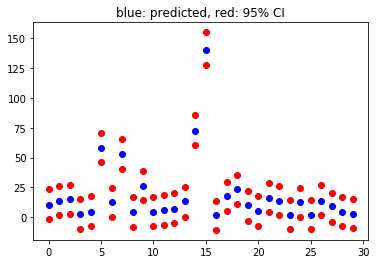

In [32]:
prstd, iv_l, iv_u = wls_prediction_std(new_lm)

plt.figure()
plt.plot(iv_u[0:30], 'o', color='r')
plt.plot(iv_l[0:30], 'o', color='r')
plt.plot(lm.fittedvalues[0:30], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()